In [ ]:
#| hide
%load_ext lineapy
%load_ext autoreload
%autoreload 2

The lineapy extension is already loaded. To reload it, use:
  %reload_ext lineapy
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


need to run command in shell first as `pipeline` is project-specific command

```{sh}
kedro pipeline create juno_all
```

In [ ]:
from loguru import logger
from typing import Union, Collection, Callable, Optional, Tuple
from typing import Any, Dict

import numpy as np
import polars as pl
import pandas

#### `Kedro`

In [ ]:
from kedro.pipeline import Pipeline, node
from kedro.pipeline.modular_pipeline import pipeline

In [ ]:
#| eval: false
from ids_finder.utils.basic import load_catalog

catalog = load_catalog()
catalog.list()

[10/15/23 11:26:02] WARNING  /Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/ ]8;id=891808;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=904;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/warnings.py#109\109]8;;\
                             kedro/io/data_catalog.py:300: FutureWarning: Defining the 'layer'                     
                             attribute at the top level is deprecated and will be removed in Kedro                 
                             0.19.0. Please move 'layer' inside the 'metadata' -> 'kedro-viz'                      
                             attributes. See                                                                       
                             https://docs.kedro.org/en/latest/visualisation/kedro-viz_visualisation                
                             .html#visualise-layers for more information.                                          
                               warnings.warn(                                                                      
                                                                                                                   


[
    'JNO_index',
    'jno.raw_jno_ss_se_1sec',
    'jno.inter_jno_ss_se_1s',
    'model.raw_jno_mswim2d',
    'model.processed_jno_mswim2d',
    'model.jno_mswim2d_rtn',
    'model.raw_jno_ss_se_1min',
    'model.preprocessed_jno_ss_se_1min',
    'sta.raw_sta_state',
    'sta.sta_mag_rtn_1s',
    'sta.sta_state_rtn_1h',
    'candidates_all_1s',
    'parameters',
    'params:tau',
    'params:jno_start_date',
    'params:jno_end_date',
    'params:jno_1s_params',
    'params:jno_1s_params.bcols',
    'params:jno_1s_params.data_resolution',
    'params:sta_1s_params',
    'params:sta_1s_params.bcols',
    'params:sta_1s_params.data_resolution'
]

## Reporting

In [ ]:
sat_states: pl.DataFrame = catalog.load("model.jno_mswim2d_rtn")
candidates: pl.DataFrame = catalog.load("jno.candidates_jno_ss_se_1s")

                    INFO     Loading data from 'model.jno_mswim2d_rtn' (GenericDataSet)...      ]8;id=961283;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=961911;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'jno.candidates_jno_ss_se_1s'                    ]8;id=192176;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=271375;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (GenericDataSet)...                                                                   

#### Pipelines

In [ ]:
# #| export
# def create_pipeline(**kwargs) -> Pipeline:
#     return pipeline([
#         node(process_candidates, inputs=["jno.candidates_jno_ss_se_1s", "model.jno_mswim2d_rtn"], outputs="candidates.jno_ss_se_1s")
#     ])
        

## Analysis

In [ ]:
import seaborn as sns
import polars.selectors as cs

In [ ]:
from fastcore.utils import patch
from pipe import select

@patch
def plot(self:pl.DataFrame, *args, **kwargs):
    return self.to_pandas().plot(*args, **kwargs)

@patch
def hvplot(self:pl.DataFrame, *args, **kwargs):
    return self.to_pandas().hvplot(*args, **kwargs)

In [ ]:
vars = ["u_mn", "L_mn", "L_mn_norm", "j0"]
def cplot(df):
    return df.plot(
        x="time", y=vars, subplots=True, logy=True
    )
    
def cplot_r(df):
    return df.plot(
        x="r", y=vars, subplots=True, logy=True
    )

every = '10d'
avg_df = df.filter(pl.col("d_star") < 100).group_by_dynamic("time", every=every).agg(cs.numeric().mean())
# upsample("time", every=every).fill_null(np.nan)

normalized_df = avg_df.with_columns(
    cs.by_name(vars) / cs.by_name(vars).mean()
)

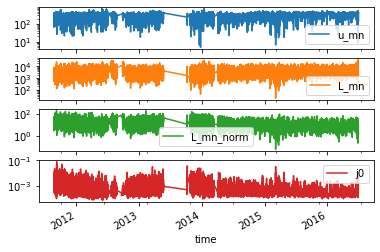

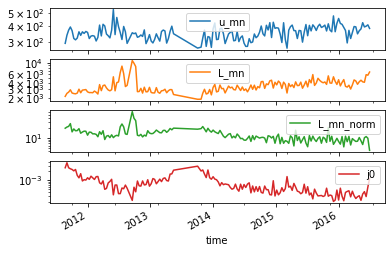

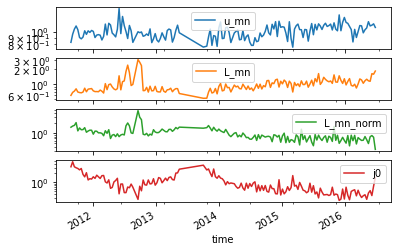

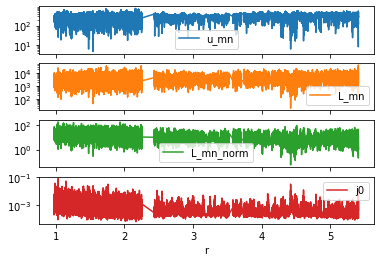

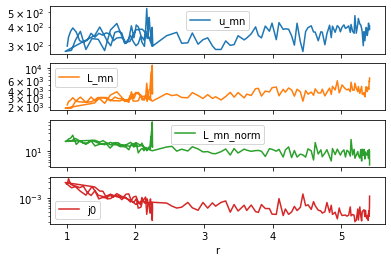

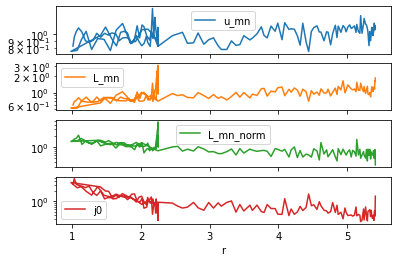

In [ ]:
dfs = [
    df, avg_df, normalized_df 
]
for func in [cplot, cplot_r]:
    list(dfs | select(lambda df: df.filter(pl.col("d_star") < 100)) | select(func))    